In [8]:
import os
import sys
projectDir = '/mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam'
sys.path.append(projectDir)

import src.config as config
config.path_to_project = projectDir
config.path_to_data = os.path.join(projectDir, 'data', 'clean')
config.path_to_images = '/home/jul/DST/Rakuten/Data/images/image_train_resized'
config.path_to_models = '/mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models'


import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

import tensorflow as tf

from Rakuten_preprocessing import Rakuten_img_path

from src.text.classifiers import TFbertClassifier
from src.image.classifiers import ViTClassifier
from src.multimodal.classifiers import TFmultiClassifier

from sklearn.metrics import f1_score

In [2]:
data_train = pd.read_csv(os.path.join(config.path_to_data, 'df_train_index.csv'))
data_train['testset'] = False
data_test = pd.read_csv(os.path.join(config.path_to_data, 'df_test_index.csv'))
data_test['testset'] = True
data = pd.concat([data_train, data_test], axis=0)

#merging text into token column
colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
data['tokens'] = data[colnames].apply(lambda row: ' '.join(s for s in row if isinstance(s, str)), axis=1)

#path to images into img_path column
data['img_path'] = Rakuten_img_path(img_folder=config.path_to_images,
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')


In [3]:
#labels of encoded classes
class_labels = data.groupby('prdtypedesignation')['prdtypeindex'].first().reset_index()
class_labels.index = class_labels['prdtypeindex']
class_labels = class_labels.drop(columns='prdtypeindex').sort_index()

## In case we want to clean up the text

In [5]:
#tokenize multiple columns
from nltk.tokenize import word_tokenize

data['tokens'] = data['tokens'].str.lower().apply(lambda x: word_tokenize(x, language='french'))

In [ ]:
def remove_wordsubset(words, wordsubset):
    #remove words in wordsubset
    words_filtered = [word for word in words if word not in wordsubset]
    return words_filtered

def remove_token_duplicates(words):
    #remove duplicated tokens, keeping the same order
    wordset = set()
    words_filtered = [wordset.add(word) or word for word in words if word not in wordset]
    return words_filtered

In [ ]:
#Removing stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
data['tokens'] = data['tokens'].apply(lambda x: remove_wordsubset(x, stop_words))

In [ ]:
#Removing puntuation
punctuations = [",", ".", "``", "@", "*", "(", ")", "...", "!", "?", "-", "_", ">", "<", ":", "/", "=", "--", "©", "~", ";", "\\", "\\\\"]
data['tokens'] = data['tokens'].apply(lambda x: remove_wordsubset(x, punctuations))

In [ ]:
#Removing duplicated tokens
data['tokens'] = data['tokens'].apply(lambda x: remove_token_duplicates(x))

In [6]:
#Converting list of tokens to string
data['tokens'] = data['tokens'].apply(lambda x:  ' '.join(x))

## Function to plot results

In [4]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))
    
    #Build confusion matrix
    conf_mat = round(pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100)

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index
        
    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,12), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()
    
    return plt

In [5]:
def plot_training_history(history):
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    axs[0].plot(history.history['loss'], label='Train')
    axs[0].plot(history.history['val_loss'], label='Test')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(history.epoch)
    axs[0].legend()
    axs[0].set_title('Loss')

    axs[1].plot(history.history['accuracy'], label='Train')
    axs[1].plot(history.history['val_accuracy'], label='Test')
    axs[1].set_xticks(history.epoch)
    axs[1].legend()
    axs[1].set_title('Accuracy')

    plt.show()
    
    return plt

## Creating train and test sets

In [6]:
Img_train = data.loc[~data['testset'], 'img_path']
Img_test = data.loc[data['testset'], 'img_path']

Txt_train = data.loc[~data['testset'], 'tokens']
Txt_test = data.loc[data['testset'], 'tokens']

y_train = data.loc[~data['testset'],'prdtypeindex']
y_test = data.loc[data['testset'],'prdtypeindex']

#To be fed into any of our sklearn classifiers, X_train and X_test
#should be dataframes with columns tokens and img_path
X_train = pd.DataFrame({'tokens': Txt_train, 'img_path': Img_train})
X_test = pd.DataFrame({'tokens': Txt_test, 'img_path': Img_test})

#Number of classes
num_classes = len(np.unique(data['prdtypeindex']))

## BERT classifier

In [7]:
model_bert = TFbertClassifier(base_name='camembert-base', from_trained = None, max_length=256, num_class=num_classes, epochs=1, batch_size=32, drop_rate=0.2)

/mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models
loading from Huggingface


2024-03-06 10:19:57.703674: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 10:19:57.704016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 10:19:57.760537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:17:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 10:19:57.760628: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-06 10:19:57.760674: I external/local_xla/xla/stream_executor

In [8]:
model_bert.fit(X_train, y_train)

2024-03-06 10:21:46.081135: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2024-03-06 10:22:18.169925: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4fc40d6e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 10:22:18.169981: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-06 10:22:18.169989: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-06 10:22:18.175827: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-06 10:22:18.928541: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709716939.089270  671721 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2123/2123 [==============================] - 1408s 640ms/step - loss: 0.8417 - accuracy: 0.7807


TFbertClassifier()

In [9]:
y_txt_pred = model_bert.predict(X_test)
y_txt_probs = model_bert.predict_proba(X_test)

f1_score(y_test, y_txt_pred, average='weighted')

531/531 [==============================] - 145s 272ms/step


0.8580015956224728

In [10]:
model_bert.save(name='Bert_test')

In [17]:
model_bert2 = TFbertClassifier(base_name='camembert-base', from_trained = 'Bert_test', max_length=256, num_class=num_classes, epochs=1, batch_size=32, drop_rate=0.2)

/mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models
loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


In [18]:
y_txt_pred = model_bert2.predict(X_test)
y_txt_probs = model_bert2.predict_proba(X_test)

f1_score(y_test, y_txt_pred, average='weighted')

531/531 [==============================] - 146s 274ms/step


0.8580015956224728

In [ ]:
plot_training_history(model_bert.history)

              precision    recall  f1-score   support

           0       0.54      0.73      0.62       623
           1       0.81      0.75      0.78       534
           2       0.93      0.95      0.94       791
           3       0.75      0.37      0.50       153
           4       0.75      0.76      0.76       974
           5       0.73      0.53      0.61       414
           6       0.98      0.97      0.98      1009
           7       0.94      0.94      0.94       161
           8       0.82      0.77      0.79       498
           9       0.93      0.74      0.83       648
          10       0.81      0.88      0.84      1015
          11       0.90      0.91      0.90       861
          12       0.92      0.94      0.93       161
          13       0.79      0.80      0.79       999
          14       0.93      0.86      0.89       165
          15       0.86      0.92      0.89       952
          16       0.76      0.86      0.81       955
          17       0.78    

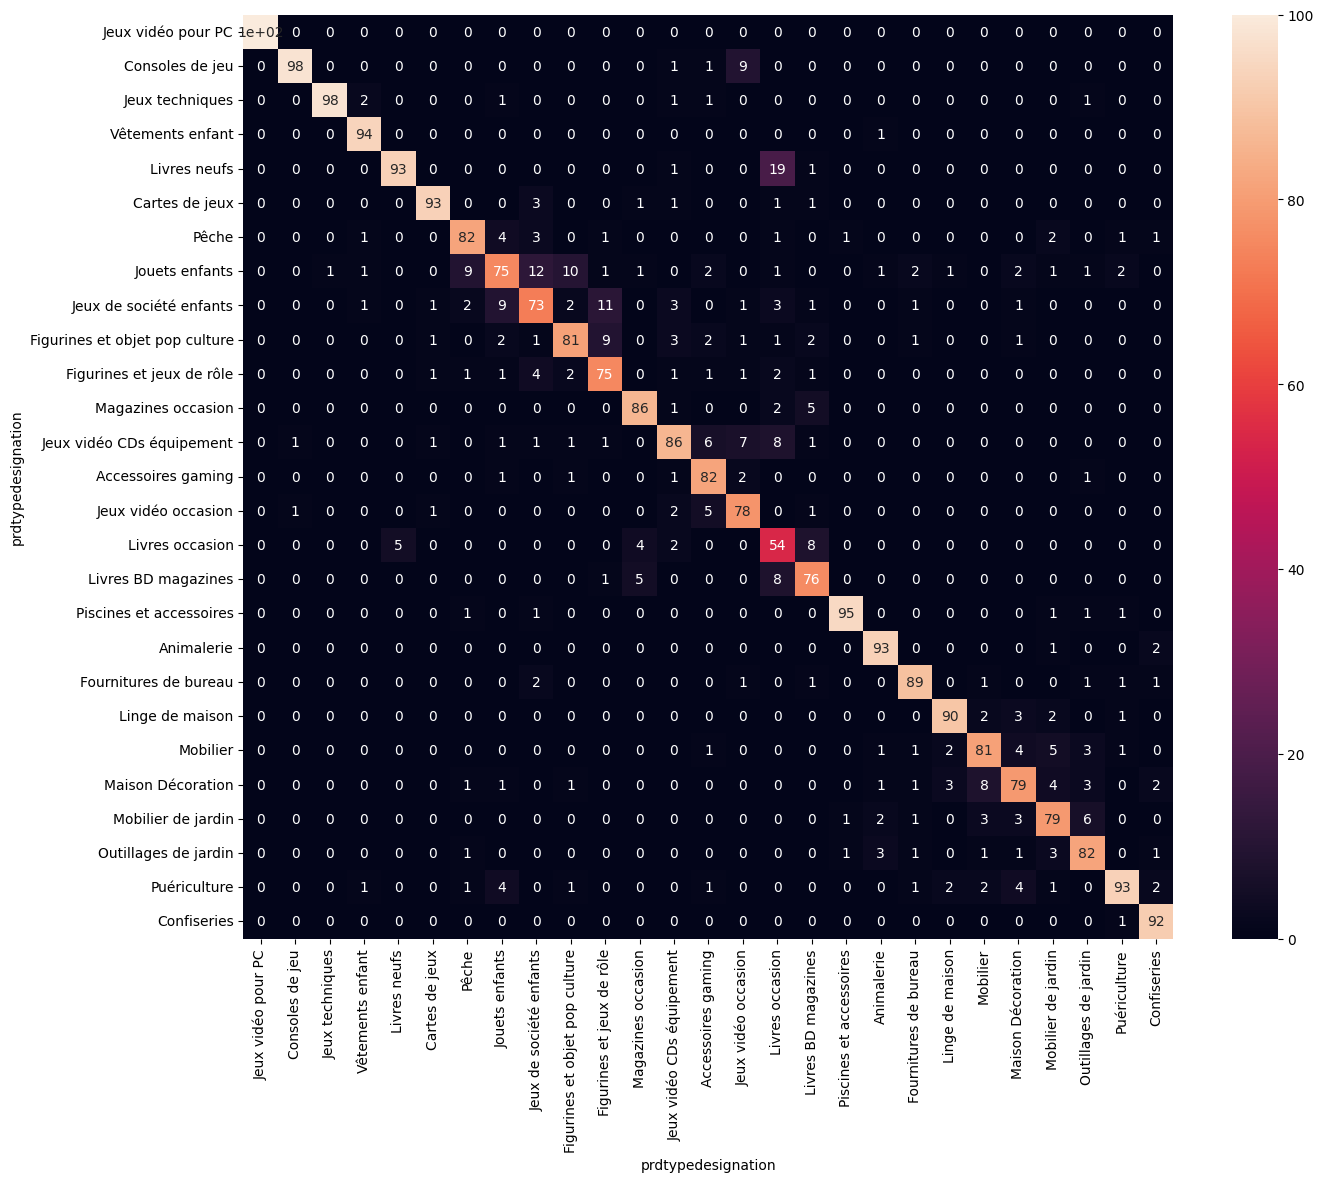

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [26]:
plot_classification_results(y_test, y_txt_pred, index=class_labels['prdtypedesignation'])

## ViT classifier

In [20]:
model_ViT = ViTClassifier(base_name='b16', from_trained = None, img_size=(224, 224, 3), num_class=27, drop_rate=0.2, epochs=1, batch_size=32, learning_rate=5e-5)

/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



In [21]:
model_ViT.fit(X_train, y_train)

Found 67932 validated image filenames.
2123/2123 [==============================] - 1172s 534ms/step - loss: 1.6725 - accuracy: 0.5185


ViTClassifier(augmentation_params={'cval': 255, 'fill_mode': 'constant',
                                   'height_shift_range': 0.1,
                                   'horizontal_flip': True,
                                   'rotation_range': 20,
                                   'width_shift_range': 0.1})

In [22]:
y_img_pred = model_ViT.predict(X_test)
y_img_probs = model_ViT.predict_proba(X_test)

f1_score(y_test, y_img_pred, average='weighted')

Found 16984 validated image filenames.
531/531 [==============================] - 130s 239ms/step
Found 16984 validated image filenames.
531/531 [==============================] - 128s 240ms/step


0.6139510746265854

In [23]:
model_ViT.save(name='ViT_test')

In [ ]:
plot_training_history(model_ViT.history)

              precision    recall  f1-score   support

           0       0.41      0.66      0.51       623
           1       0.60      0.69      0.64       534
           2       0.77      0.95      0.85       791
           3       0.49      0.20      0.28       153
           4       0.50      0.32      0.39       974
           5       0.34      0.33      0.33       414
           6       0.65      0.72      0.69      1009
           7       0.87      0.52      0.65       161
           8       0.54      0.32      0.40       498
           9       0.57      0.40      0.47       648
          10       0.60      0.61      0.60      1015
          11       0.78      0.83      0.80       861
          12       0.69      0.70      0.69       161
          13       0.42      0.64      0.51       999
          14       0.88      0.21      0.34       165
          15       0.78      0.81      0.79       952
          16       0.72      0.64      0.68       955
          17       0.71    

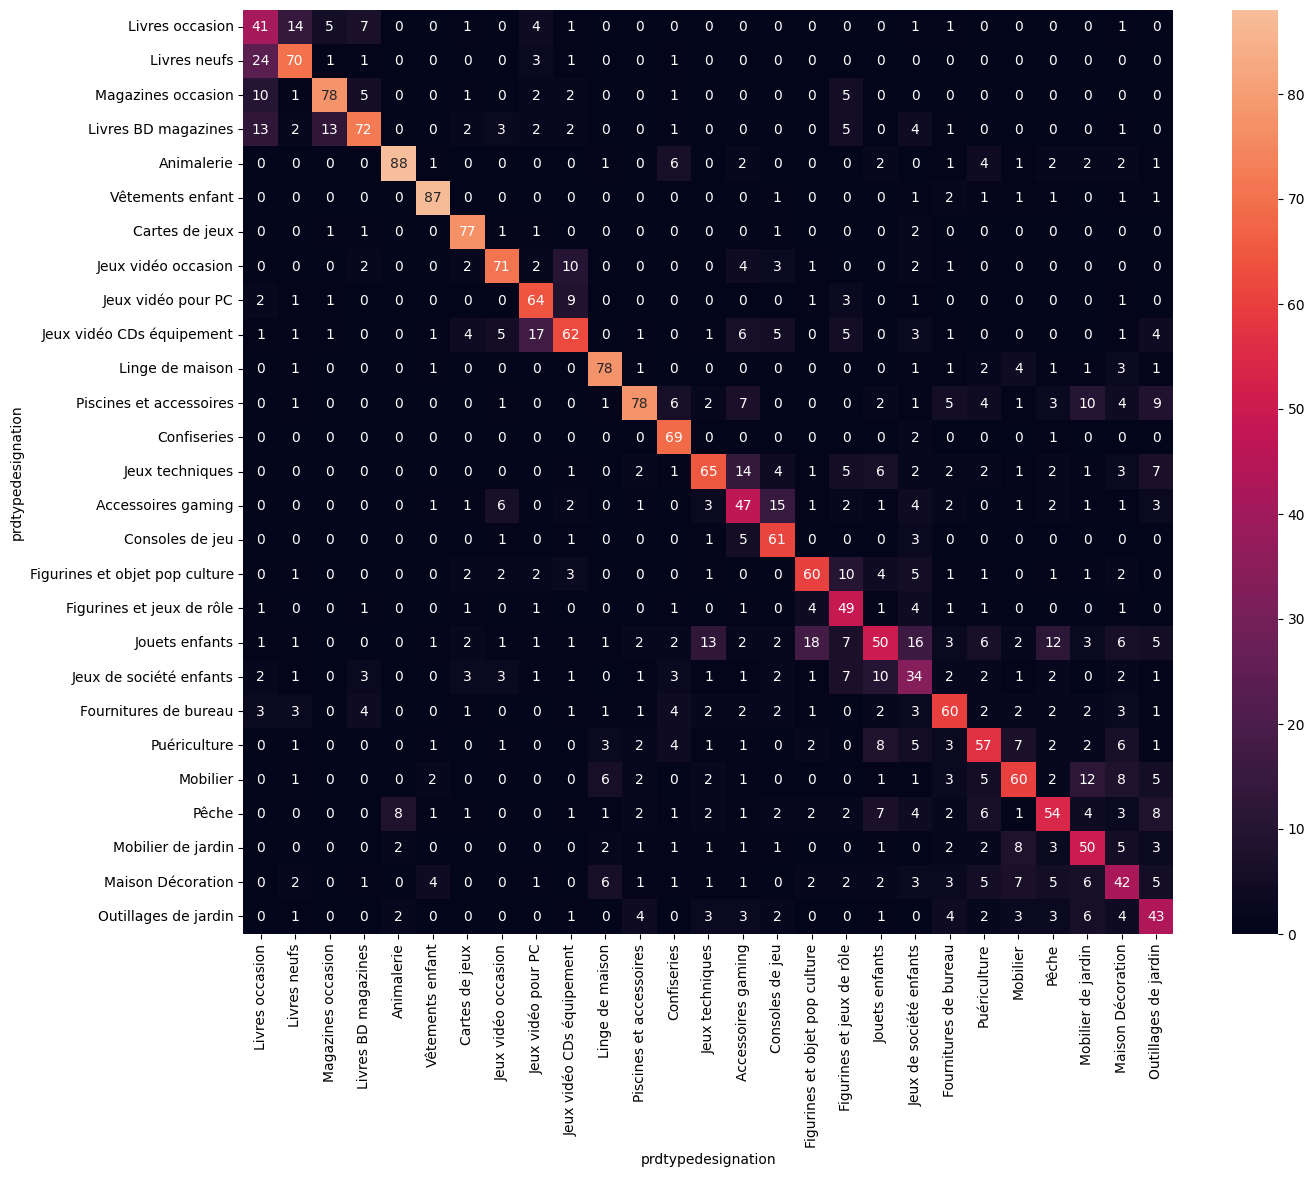

<module 'matplotlib.pyplot' from '/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/matplotlib/pyplot.py'>

In [25]:
plot_classification_results(y_test, y_img_pred, index=class_labels['prdtypedesignation'])

## Voting classifier with Bert and ViT

In [14]:
from sklearn.ensemble import VotingClassifier

model_txt = TFbertClassifier(base_name='camembert-base', from_trained = 'Bert_test', max_length=256, num_class=27, drop_rate=0.2, epochs=0)
model_img = ViTClassifier(base_name='b16', from_trained = 'ViT_test', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, batch_size=32, learning_rate=5e-5, epochs=0)

voting_clf = VotingClassifier(estimators = [('txt_clf', model_txt), ('img_clf', model_img)], voting='soft', weights=[0.6, 0.4])
voting_clf.fit(X_train, y_train)

All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/text/../../models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



loading weights from  ViT_test


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/text/../../models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



loading weights from  ViT_test


VotingClassifier(estimators=[('txt_clf',
                              TFbertClassifier(epochs=0,
                                               from_trained='Bert_test')),
                             ('img_clf',
                              ViTClassifier(augmentation_params={'cval': 255,
                                                                 'fill_mode': 'constant',
                                                                 'height_shift_range': 0.1,
                                                                 'horizontal_flip': True,
                                                                 'rotation_range': 20,
                                                                 'width_shift_range': 0.1},
                                            epochs=0,
                                            from_trained='ViT_test'))],
                 voting='soft', weights=[0.6, 0.4])

In [11]:
voting_pred = voting_clf.predict(X_test)
f1_score(y_test, voting_pred, average='weighted')

2024-03-06 02:10:01.856308: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 154s 275ms/step
Found 16984 validated image filenames.


2024-03-06 02:12:36.438034: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 02:12:39.342531: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 140s 251ms/step


0.8585865972586947

## Stacking classifier with Bert and ViT

In [12]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

model_txt = TFbertClassifier(base_name='camembert-base', from_trained = 'Bert_test', max_length=256, num_class=27, drop_rate=0.2, epochs=0)
model_img = ViTClassifier(base_name='b16', from_trained = 'ViT_test', img_size=(224, 224, 3), num_class=27, drop_rate=0.2, batch_size=32, learning_rate=5e-5, epochs=0)
final_clf = LogisticRegression(C=1.0, penalty='l2')

stacking_clf = StackingClassifier(estimators = [('txt_clf', model_txt), ('img_clf', model_img)], final_estimator=final_clf, cv='prefit', stack_method='predict_proba')
stacking_clf.fit(X_test, y_test)

loading from Local


All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/GitHub/RakutenTeam/src/text/../../models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


loading weights from  Bert_test


/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning:

Resizing position embeddings from 24, 24 to 14, 14



loading weights from  ViT_test
531/531 [==============================] - 148s 274ms/step
Found 16984 validated image filenames.


2024-03-06 08:50:07.369828: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 08:50:10.671323: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


531/531 [==============================] - 137s 244ms/step


StackingClassifier(cv='prefit',
                   estimators=[('txt_clf',
                                TFbertClassifier(epochs=0,
                                                 from_trained='Bert_test')),
                               ('img_clf',
                                ViTClassifier(augmentation_params={'cval': 255,
                                                                   'fill_mode': 'constant',
                                                                   'height_shift_range': 0.1,
                                                                   'horizontal_flip': True,
                                                                   'rotation_range': 20,
                                                                   'width_shift_range': 0.1},
                                              epochs=0,
                                              from_trained='ViT_test'))],
                   final_estimator=LogisticRegression(),
                   stack_method='predict_proba')

In [13]:
stacking_pred = stacking_clf.predict(X_test)
f1_score(y_test, stacking_pred, average='weighted')

531/531 [==============================] - 146s 274ms/step
Found 16984 validated image filenames.
531/531 [==============================] - 130s 245ms/step


0.868771593772429

## MultiModal transformer

In [10]:
model_multi = TFmultiClassifier(txt_base_name='camembert-base', img_base_name='b16', from_trained = None, 
                                 max_length=256, img_size=(224, 224, 3), augmentation_params=None,
                                    num_class=27, drop_rate=0.2,
                                    epochs=2, batch_size=16, learning_rate=5e-5, callbacks=None)

All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/Julien Fournier/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


In [11]:
model_multi.fit(X_train, y_train)

Found 16 validated image filenames.
Epoch 1/2
Found 16 validated image filenames.
Found 16 validated image filenames.
Found 16 validated image filenames.


2024-03-06 14:59:17.060561: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-06 14:59:20.150501: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-06 14:59:20.913456: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-06 14:59:22.875597: I external/local_xla/xla/service/service.cc:168] XLA service 0x71f38190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 14:59:22.875646: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-06 14:59:22.875654: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2024-03-06 14:59:22.881705: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disablin

  11/4246 [..............................] - ETA: 48:58 - loss: 3.4631 - accuracy: 0.0284Found 16 validated image filenames.


KeyboardInterrupt: 

In [34]:
y_multi_pred = model_multi.predict(X_test)

f1_score(y_test, y_multi_pred, average='weighted')

{'input_ids': <tf.Tensor: shape=(16984, 256), dtype=int32, numpy=
array([[    5,  3810,     8, ...,     1,     1,     1],
       [    5, 13864, 10959, ...,     1,     1,     1],
       [    5,    18,  1590, ...,   135,   151,     6],
       ...,
       [    5,  6737,   160, ...,     1,     1,     1],
       [    5,  6589, 17777, ...,     1,     1,     1],
       [    5, 17426,  3990, ...,     1,     1,     1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(16984, 256), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}
Found 16 validated image filenames.
Found 16 validated image filenames.
Found 16 validated image filenames.
Found 16 validated image filenames.
1062/1062 [==============================] - 305s 281ms/step


0.8658199922268804

In [37]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from vit_keras import vit

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, ClassifierMixin

import os

import src.config as config


def build_multi_model(txt_base_model, img_base_model, from_trained=None, max_length=256, img_size=(224, 224, 3),
                      num_class=27, drop_rate=0.0, activation='softmax'):
    """_summary_

    Args:
        base_name (str, optional): _description_. Defaults to 'camembert-base'.
    """
    #Bert branch    
    input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
    attention_mask = Input(shape=(max_length,), dtype='int32', name='attention_mask')

    #Bert transformer model
    txt_base_model._name = 'bert_layers'
    txt_transformer_layer = txt_base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    txt_output = txt_transformer_layer[0][:, 0, :]
    # x = Dense(128, activation='relu', name='Dense_txt_1')(x)
    # x = Dropout(rate=drop_rate, name='Drop_out_top_1')(x)
    txt_model = Model(inputs={'input_ids': input_ids, 'attention_mask': attention_mask}, outputs=txt_output)
    
    #ViT transformer model
    input_img = Input(shape=img_size, name='inputs')
    img_output = img_base_model(input_img)
    img_model = Model(inputs=input_img, outputs=img_output)
    
    #Concatenate text and image models
    x = Concatenate()([txt_model.output, img_model.output])

    #Dense layers for classification
    x = Dropout(rate=drop_rate)(x)
    x = Dense(units=128, activation='relu', name='Dense_multi_1')(x)
    outputs = Dense(units=num_class, activation=activation, name='multi_classification_layer')(x)

    model = Model(inputs=[txt_model.input, img_model.input], outputs=outputs)
    
    if from_trained is not None:
        if isinstance(from_trained, dict):
            if 'text' in from_trained.keys():
                txt_model_path = os.path.join(config.path_to_models, 'trained_models', from_trained['text'])
                print("loading weights for BERT from ", from_trained['text'])
                model.load_weights(txt_model_path + '/weights.h5', by_name=True, skip_mismatch=True)
            if 'image' in from_trained.keys():
                img_model_path = os.path.join(config.path_to_models, 'trained_models', from_trained['image'])
                print("loading weights for ViT from ", from_trained['image'])
                model.load_weights(img_model_path + '/weights.h5', by_name=True, skip_mismatch=True)
        else:
            model_path = os.path.join(config.path_to_models, 'trained_models', from_trained)
            print("loading weights for multimodal model from ", from_trained)
            model.load_weights(model_path + '/weights.h5', by_name=True, skip_mismatch=True)
        
    
    return model

from keras.utils import Sequence

class MultimodalDataGenerator(Sequence):
    def __init__(self, img_data_generator, img_path, text_tokenized, labels, batch_size=32, target_size = (224, 224), shuffle=True):
        self.img_data_generator = img_data_generator
        self.dataframe = pd.DataFrame({'filename':img_path})#dataframe.copy()
        self.text_tokenized = text_tokenized
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:min((index + 1) * self.batch_size, len(self.dataframe))]
        batch_indexes_tensor = tf.convert_to_tensor(batch_indexes, dtype=tf.int32)
        
        batch_df = self.dataframe.iloc[batch_indexes]
        
        img_generator = self.img_data_generator.flow_from_dataframe(dataframe=batch_df, target_size=self.target_size,
                                                                    x_col="filename", y_col=None,class_mode=None,
                                                                    batch_size=len(batch_df), shuffle=False)
        
        images = np.concatenate([img_generator.next() for _ in range(len(img_generator))], axis=0)
        
        token_ids = tf.gather(self.text_tokenized['input_ids'], batch_indexes_tensor, axis=0)
        attention_mask = tf.gather(self.text_tokenized['attention_mask'], batch_indexes_tensor, axis=0)
        
        labels = self.labels[batch_indexes].values
        
        return [{"input_ids": token_ids, "attention_mask": attention_mask}, images], labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

class TFmultiClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, txt_base_name='camembert-base', img_base_name='b16', from_trained = None, 
                 max_length=256, img_size=(224, 224, 3), augmentation_params=None,
                 num_class=27, drop_rate=0.2,
                 epochs=1, batch_size=32, learning_rate=5e-5, callbacks=None):
        """_summary_

        Args:
            base_name (str, optional): _description_. Defaults to 'camembert-base'.
            from_trained (_type_, optional): _description_. Defaults to None.
            max_length (int, optional): _description_. Defaults to 256.
            num_class (int, optional): _description_. Defaults to 27.
            drop_rate (int, optional): _description_. Defaults to 0.
            activation (str, optional): _description_. Defaults to 'softmax'.
        """
        # path to locally saved huggingface Bert model
        txt_base_model_path = os.path.join(config.path_to_models, 'base_models', txt_base_name)
        
        #Loading bert model base
        if not os.path.isdir(txt_base_model_path):
            # If the hugginface pretrained Bert model hasn't been yet saved locally, 
            # we load and save it from HuggingFace
            txt_base_model = TFAutoModel.from_pretrained(txt_base_name)
            txt_base_model.save_pretrained(txt_base_model_path)
            self.tokenizer = AutoTokenizer.from_pretrained(txt_base_name)
            self.tokenizer.save_pretrained(txt_base_model_path)
        else:
            txt_base_model = TFAutoModel.from_pretrained(txt_base_model_path)
            self.tokenizer = AutoTokenizer.from_pretrained(txt_base_name)
        
        #Loading ViT model base    
        default_action = lambda: print("img_base_name should be one of: b16, b32, L16 or L32")
        img_base_model = getattr(vit, 'vit_' + img_base_name, default_action)\
                                    (image_size = img_size[0:2], pretrained = True, 
                                     include_top = False, pretrained_top = False)
        
        self.model = build_multi_model(txt_base_model=txt_base_model, img_base_model=img_base_model,
                                       from_trained=from_trained, max_length=max_length, img_size=img_size,
                                       num_class=num_class, drop_rate=drop_rate, activation='softmax')
        
        self.max_length = max_length
        self.img_size = img_size
        self.txt_base_name = txt_base_name
        self.img_base_name = img_base_name
        self.from_trained = from_trained
        self.num_class = num_class
        self.drop_rate = drop_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        if augmentation_params is not None:
            self.augmentation_params = augmentation_params
        else:
            self.augmentation_params = dict(rotation_range=20, width_shift_range=0.1,
                                            height_shift_range=0.1, horizontal_flip=True,
                                            fill_mode='constant', cval=255)
        self.callbacks = callbacks
        
        if from_trained is not None:
            self.is_fitted_ = True
        
        
        
        
    def fit(self, X, y):
        """_summary_

        Args:
            X (_type_): _description_
            y (_type_): _description_
            epochs (int, optional): _description_. Defaults to 1.
            batch_size (int, optional): _description_. Defaults to 32.
            learning_rate (_type_, optional): _description_. Defaults to 5e-5.

        Returns:
            _type_: _description_
        """
        
        if self.epochs > 0:
            dataset = self._getdataset(X, y, training=True)
            
            optimizer = Adam(learning_rate=self.learning_rate)
            self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            self.history = self.model.fit(dataset, epochs=self.epochs, callbacks=self.callbacks)
        else:
            self.history = []
            
        self.is_fitted_ = True
        
        return self
    
    def predict(self, X):
        dataset = self._getdataset(X, training=False)
        preds = self.model.predict(dataset)
        return np.argmax(preds, axis=1)
    
    
    def predict_proba(self, X):
        """
        Predicts class probabilities for each input.
        """
        dataset = self._getdataset(X, training=False)
        probs = self.model.predict(dataset)
        
        return probs
    
    
    def _getdataset(self, X, y=None, training=False):
        """_summary_

        Args:
            X (_type_): _description_
            y (_type_, optional): _description_. Defaults to None.
            training (bool, optional): _description_. Defaults to False.
        """
        if y is None:
            y = 0
            
        df = pd.DataFrame({'labels': y, 'tokens': X['tokens'], 'img_path': X['img_path']})
        
        if training:
            shuffle = True
            params = self.augmentation_params
        else:
            shuffle = False
            params = dict(rotation_range=0, width_shift_range=0,
                          height_shift_range=0, horizontal_flip=False,
                          fill_mode='constant', cval=255)

        #Data generator for the train and test sets
        img_generator = ImageDataGenerator(rescale = 1./255, samplewise_center = True, samplewise_std_normalization = True,
                                            rotation_range=params['rotation_range'], 
                                            width_shift_range=params['width_shift_range'], 
                                            height_shift_range=params['height_shift_range'],
                                            horizontal_flip=params['horizontal_flip'],
                                            fill_mode=params['fill_mode'],
                                            cval=params['cval'])
        
        X_tokenized = self.tokenizer(df['tokens'].tolist(), padding="max_length", truncation=True, max_length=self.max_length, return_tensors="tf")
        
        dataset = MultimodalDataGenerator(img_generator, df['img_path'], X_tokenized, df['labels'], 
                                          batch_size=self.batch_size, target_size = self.img_size[:2], shuffle=shuffle)
        
        return dataset
    
    
    
    def save(self, name):
        """_summary_

        Args:
            dirpath (_type_): _description_
            name (_type_): _description_
        """
        #path to the directory where the model will be saved
        save_path = os.path.join(config.path_to_models, 'trained_models', name)
        
        #Creating it if necessary
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            
        #Saving model's weights to that location
        self.model.save_weights(os.path.join(save_path, 'weights.h5'))

